# BE - A probabilistic counterpart to ruin probabilities

Deadline: 7/12/2022

Authors: Yousra Bouchikhi, Hamza Belkarkor et Dylan Lebreton

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy
import math
import numpy.random as rd

## 1 - Cramér-Lundberg simulation

This part will be devoted to the simulation of a risk process as defined as in the Cramér-Lunberg model:
$$
R_t(u) = u + ct - \sum_{i=1}^{N_t}Y_i
$$

With:
* $R_t(u)$ the risk process (can be seen as the wealth of an insurance company)
* $u$ the initial capital
* $ct$ a constant premium rate per unit time
* $N_t$ an homogeneous Poisson process giving the number of happened claims at time $t$
* $Y_i$ the size of the ith claim

### 1.1 - Claim sizes definition

Let us define here four types of distributions for the sizes of the claims.

In [4]:
def lognormal_claims(n:int, mean:float=0.0, sigma:float=1.0):
    """
    Return n samples from a log-normal distribution and its theotical mean 
    """
    return np.random.lognormal(mean=mean, sigma=sigma, size=n), mean

def pareto_claims(n:int, a:float=10.):
    """
    Return n samples from a pareto distribution and its theotical mean 
    """
    return np.random.pareto(a=a, size=n) + 1.0, (a / (a - 1.0))

def exponential_claims(n:int, scale:float=0.5):
    """
    Return n samples from a pareto distribution and its theotical mean 
    """
    return np.random.exponential(scale=scale, size=n), scale

def weibull_claims(n:int, a:float=0.3):
    """
    Return n samples from a weibull distribution and its theotical mean 
    """
    return np.random.weibull(a=a, size=n), scipy.special.gamma(1.0 + (1.0 / a))

def claims(n:int, distrib:str="pareto", **kwargs):
    allowed_distribs = ["pareto", "lognormal", "exponential", "weibull"]
    if distrib not in allowed_distribs:
        raise Exception(f"distrib must be {allowed_distribs}, received '{distrib}'")

    return eval(f"{distrib}_claims")(n, **kwargs)

We plot now the distribution of the different laws of the claim sizes for 100,000 considered claims.

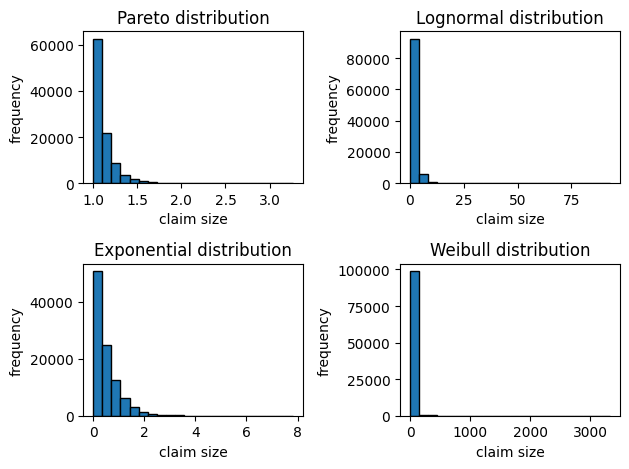

In [5]:
n = 100000

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)

axs[0, 0].hist(claims(n,"pareto")[0], edgecolor="k", bins=22)
axs[0, 0].set_title('Pareto distribution')

axs[0, 1].hist(claims(n,"lognormal")[0], edgecolor="k", bins=22)
axs[0, 1].set_title('Lognormal distribution')

axs[1, 0].hist(claims(n,"exponential")[0], edgecolor="k", bins=22)
axs[1, 0].set_title('Exponential distribution')

axs[1, 1].hist(claims(n,"weibull")[0], edgecolor="k", bins=22)
axs[1, 1].set_title('Weibull distribution')

for ax in axs.flat:
    ax.set(xlabel='claim size', ylabel='frequency')

plt.tight_layout()
plt.show()

### 1.2 - Homogeneous poisson process simulation

Now the claim sizes distributions are defined, we can model the homogeneous poisson process $N_t$ that will give the number of claims at time $t$.

First we define a function returning arrival times of the poisson process.

In [6]:
def poisson_process_arrival_times(lam:float=2.0,Tmax:int=3*12):
    """
    Function returning the arrival times on [0, Tmax] of a Poisson process with intensity lam.
    We consider month as temporal unit, so we choose Tmax as 3 years.
    """
    tau=[0.0]
    e=rd.exponential(1/lam,1)
    i=1
    while e<=Tmax:
        tau.append(float(e))
        i+=1
        e=e+rd.exponential(1/lam,1)
    return tau

Here is plotted an example of poisson process for $\lambda=2$ and $T_{max}=10$.

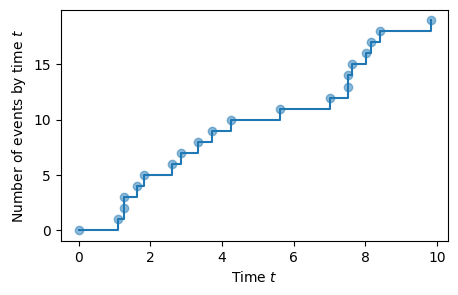

In [7]:
arrival_times = poisson_process_arrival_times(Tmax=10)

# at each arrival time, we increase the number of events by one
events_numbers = [0]
for i in range(1,len(arrival_times)):
    events_numbers.append(i)

plt.figure(figsize=(5,3))
plt.step(arrival_times, events_numbers,where="post")
plt.plot(arrival_times,events_numbers,"C0o",alpha=0.5)
plt.ylabel("Number of events by time $t$")
plt.xlabel("Time $t$")
plt.show()

Let us define now a function equivalent to the random variable $N_t$ in the Cramér-Lunberg model.

In [8]:
def N(t, arrival_times, Tmax):
    """
    Function returning the number of events at time t for given arrival_times on [0, Tmax].
    """
    if t > Tmax:
        raise Exception(f"t (={t}) must be less than or equal to Tmax (={Tmax})")
    else:
        if t == Tmax:
            return len(arrival_times) - 1
        else:
            return np.where(arrival_times - t <= 0)[0][-1]

By discretizing <code>[0,Tmax]</code> temporally, we obtain the same graph as before using the same arrival times. 

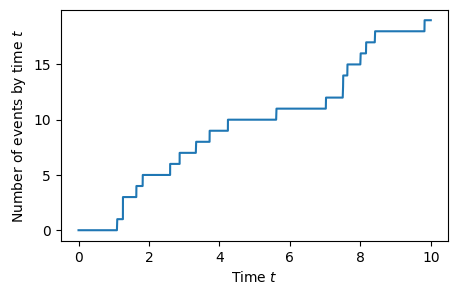

In [9]:
plt.figure(figsize=(5,3))
t_grid = np.sort(np.concatenate([arrival_times, np.arange(0.01, 10.01, 0.01)]))
plt.plot(t_grid,[N(t, arrival_times, 10.0) for t in t_grid])
plt.ylabel("Number of events by time $t$")
plt.xlabel("Time $t$")
plt.show()

### 1.3 - Cramér-Lunberg risk process

Now the claim sizes distributions and the homogeneous poisson process are defined, we can model the risk process.

First, we define a function giving the total of claim sizes $\sum_{i=1}^{N_t}Y_i$ at time $t$.

In [10]:
def C(t, Tmax, arrival_times, claims):
    return np.cumsum(claims[:N(t,arrival_times,Tmax)+1])[-1]

We plot here the evolution of this quantity for $t \in [0, T_{max}=10]$  by choosing a lognormal distribution for the claim sizes.

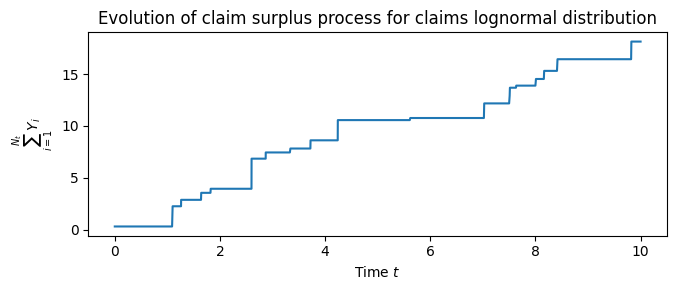

In [11]:
plt.figure(figsize=(7,3))
t_grid = np.sort(np.concatenate([arrival_times, np.arange(0.01, 10.01, 0.01)]))
claims_ = claims(len(arrival_times), "lognormal")[0]
plt.plot(t_grid, [C(t, 10.0, arrival_times, claims_) for t in t_grid])
plt.xlabel("Time $t$")
plt.ylabel("$\sum_{i=1}^{N_t}Y_i$")
plt.title("Evolution of claim surplus process for claims lognormal distribution")
plt.tight_layout()
plt.show()

We can now define the entire Cramér-Lunberg risk process.

In [12]:
def risk_process(initial_capital, premium, Tmax=3*12, lam=2.0, claims_distrib="pareto", **kwargs):

    # time step for time discretization
    # default to 100 points in [0, Tmax] 
    if "nt" in kwargs.keys():
        nt = kwargs["nt"]
        t_grid = np.array([i*Tmax / float(nt) for i in range(nt+1)])
    else:
        t_grid = np.array([i*Tmax/100. for i in range(100+1)])

    # arrival times for poisson process
    arrival_times = poisson_process_arrival_times(lam, Tmax)

    # add of the arrival times in the t_grid
    t_grid = np.sort(np.concatenate([arrival_times[1:], t_grid]))


    # generation of claims and retrieve theoritical mean 
    claims_, mean = claims(len(arrival_times), claims_distrib, **kwargs)
    
    # insertion of 0.0 at the begining of the claims for t=0
    claims_ = np.insert(claims_, 0, 0.0)
    
    # computation of the result
    process = []
    for t in t_grid:
        process.append([t,initial_capital + premium * t - C(t,Tmax,arrival_times,claims_)])

    process = np.array(process)
    
    return process, mean

We plot here the evolution of an example of risk process with same parameters as used as in practical work with Mr. Reveillac.

Text(0, 0.5, '$R_t(u=10)$')

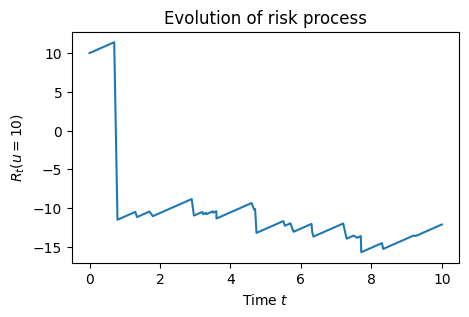

In [13]:
process, mean = risk_process(10, 2, Tmax=10, lam=2.0, claims_distrib="lognormal")

plt.figure(figsize=(5,3))
plt.plot(process[:,0], process[:,1])
plt.title("Evolution of risk process")
plt.xlabel("Time $t$")
plt.ylabel("$R_t(u=10)$")

## 2 - Determination of the net profit condition

The purpose of this section is to show numerically the 1.0 ratio theorem. We recall the theorem : 
* If the premium $c$ is greater than $\rho = \lambda \mathbb{E}(Y_1)$, then the probability of ruin is lesser than 1.0 almost surely when $t \rightarrow + \infty$
* If the premium $c$ is lesser than $\rho = \lambda \mathbb{E}(Y_1)$, then the probability of ruin is almost surely equal to 1.0 when $t\rightarrow + \infty$

We firstly define some parameters. We choose <code>Tmax</code> = 

In [15]:
Tmax = 99*12
distrib = "pareto"
lam = 2.0
monte_carlo = 20

premiums = np.arange(1.5, 2.5, 0.05)
ruins = []

for premium in premiums:
    ruin_bool = []
    for mc in range(monte_carlo):
        print(f"premium : {round(premium,3)} | monte-carlo : {mc}/{monte_carlo-1}")
        process, mean = risk_process(initial_capital=100, premium=premium, Tmax=Tmax, lam=lam, claims_distrib=distrib)
        # plt.plot(process[:,0], process[:,1])
        # plt.show()
        # if ruin
        if np.min(process[:,1]) < 0:
            ruin_bool.append(1)
        else:
            ruin_bool.append(0)
    ruins.append(np.sum(ruin_bool)/float(len(ruin_bool)))

rho = mean * lam


premium : 1.5 | monte-carlo : 0/19
premium : 1.5 | monte-carlo : 1/19
premium : 1.5 | monte-carlo : 2/19
premium : 1.5 | monte-carlo : 3/19
premium : 1.5 | monte-carlo : 4/19
premium : 1.5 | monte-carlo : 5/19
premium : 1.5 | monte-carlo : 6/19
premium : 1.5 | monte-carlo : 7/19
premium : 1.5 | monte-carlo : 8/19
premium : 1.5 | monte-carlo : 9/19
premium : 1.5 | monte-carlo : 10/19
premium : 1.5 | monte-carlo : 11/19
premium : 1.5 | monte-carlo : 12/19
premium : 1.5 | monte-carlo : 13/19
premium : 1.5 | monte-carlo : 14/19
premium : 1.5 | monte-carlo : 15/19
premium : 1.5 | monte-carlo : 16/19
premium : 1.5 | monte-carlo : 17/19
premium : 1.5 | monte-carlo : 18/19
premium : 1.5 | monte-carlo : 19/19
premium : 1.55 | monte-carlo : 0/19
premium : 1.55 | monte-carlo : 1/19
premium : 1.55 | monte-carlo : 2/19
premium : 1.55 | monte-carlo : 3/19
premium : 1.55 | monte-carlo : 4/19
premium : 1.55 | monte-carlo : 5/19
premium : 1.55 | monte-carlo : 6/19
premium : 1.55 | monte-carlo : 7/19
pr

KeyboardInterrupt: 

In [ ]:
ruins

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## 3 - Expression of ruin probability

### 3.1 - With pareto claim distribution

In [ ]:
def psi_Y_pareto(u, rho, xm, k):
    a = rho/(1. - rho)
    return a * (1 + ((xm ** (k-1))/k) * ((1/(u + xm) ** (k-1)) - (1/ xm ** (k-1))))

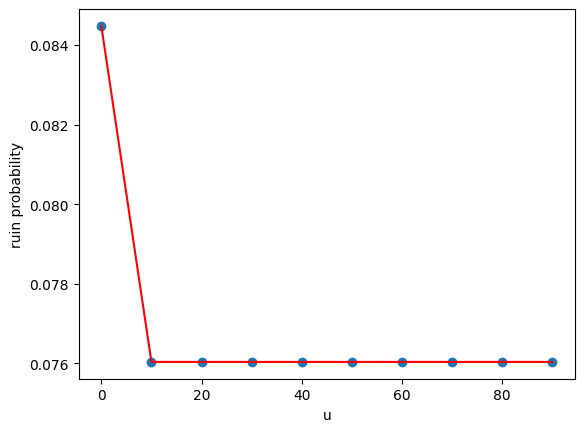

In [ ]:
fig, ax = plt.subplots()
U = np.linspace(0, 90, 10)
n = 100000
b = 10
Y = np.random.pareto(a=10, size=n)
xm = 1
lam = 0.7
rho = lam * np.mean(Y)
k = b
L = []
for u in U:
    psi = psi_Y_pareto(u, rho, xm, k)
    L.append(psi)
plt.plot(U, L, "r")
plt.scatter(U, L)
plt.xlabel("u")
plt.ylabel("ruin probability")
ax.ticklabel_format(useOffset=False)
plt.show()

### 3.2 - With log-normal claim distribution


In [ ]:
def f(y, mu, sigma):
    return((sigma / (math.log(y + 0.0001) * math.sqrt(2*math.pi))) * math.exp((-1/2) \
    * ((math.log(y + 0.0001) - mu)/ sigma)**2))

In [ ]:
def psi_Y_lognormal1(u, rho, mu, sigma):
    a = rho/(1. - rho)
    y = sp.Symbol('y')
    res = a * (1 - math.exp(-(mu + 1/2 * sigma ** 2))) * sp.integrate(f(y, mu, sigma),(y,0,u))
    return 

In [ ]:
from scipy.integrate import quad 

def psi_Y_lognormal2(u, rho, mu, sigma):
    a = rho/(1. - rho)
    res, err = a * (1 - math.exp(-(mu + 1/2 * sigma ** 2))) * quad(f, 0, u, args=(mu, sigma))
    return res, err

In [ ]:
def integrale(f, a, b, n):
    somme = 0
    h = float(b-a) / n
    x = a
    for i in range(0, n + 1):
        somme += f(x, mu, sigma) * h
        x += h
    return somme

def psi_Y_lognormal_app(u, rho, mu, sigma):
    a = rho/(1. - rho)
    res = a * (1 - math.exp(-(mu + 1/2 * sigma ** 2))) * integrale(f, 0, u, 1000)
    return res 


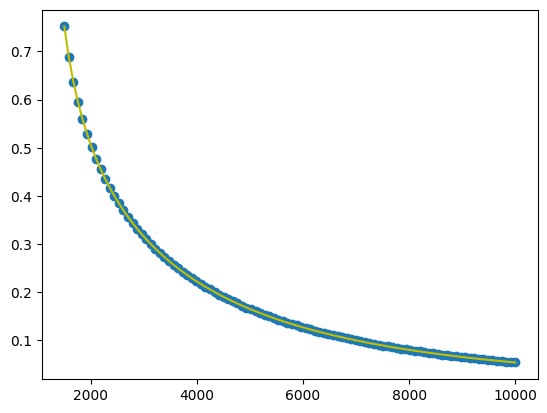

In [ ]:
U = np.linspace(1500 , 10000, 100)
n = 100000
Y, mean = lognormal_claims(n, 0.0, 1.)
lam = 0.3
rho = lam * np.mean(Y)
mu = 0.
sigma = 1.
L = []
for u in U:
    psi = psi_Y_lognormal_app(u, rho, mu, sigma)
    L.append(psi)
plt.plot(U, L, "y")
plt.scatter(U, L)
plt.show()

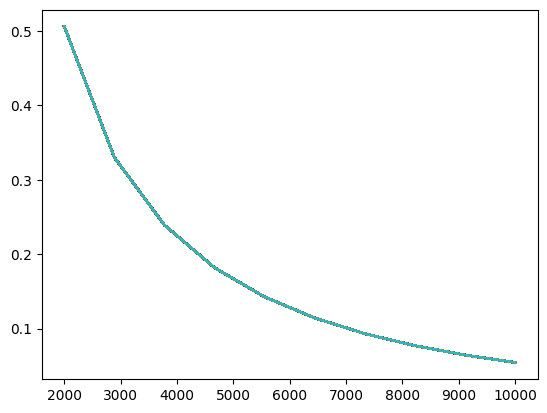

In [ ]:
nr = 300
U = np.linspace(2000 , 10000, 10)

esp_est_psi = []

for u in U:
    psi_mean = np.zeros(nr)
    for i in range(nr):
        lam = 0.3
        rho = lam * np.mean(Y)
        psi = psi_Y_lognormal_app(u, rho, mu, sigma)
        psi_mean[i] = np.mean(psi)
    esp_est_psi += [psi_mean]

plt.plot(U, esp_est_psi)
plt.show()

## 4 - Simulation of ruin probability and comparison with its LDP approximation

In [ ]:
from func import *

def Ruin_proba(u_min,u_max,p,law,maxtime, lambdap) :
    ruin_prob = []
    for u in range(u_min,u_max) :
        ruin = []
        for i in range(300):
            rp = Rprocess(u,p,law,maxtime,lambdap)
            for time_risk in rp:
                if time_risk[1]<0 :
                    ruin.append(time_risk[0])
                    break

        proba = len(ruin)/300
        ruin_prob.append(proba)
    return ruin_prob


### 4.1 - Ruin probabilities and an optimal exponential interpolation

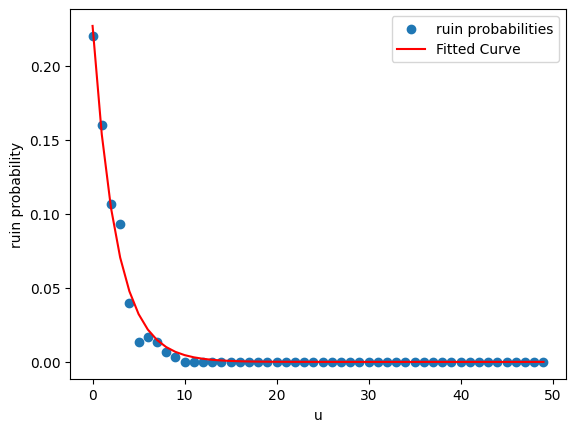

In [ ]:
#pour les paramètres : loi binomiale de paramètre p = 0.3 et Te = 100 (maxtime) et lambda= 1 alors 
#rho = lambda*E(Y1) = 30
#donc pour avoir ruine il suffit de prendre un premium <=30
from scipy.optimize import curve_fit

x = range(0,50)
ruinproba_list = Ruin_proba(0,50,10, 1, 100, 1)

def fun_exp(u,C,theta):
    return C*np.exp(-theta*u)

popt, pcov= curve_fit(fun_exp, x, ruinproba_list)

plt.figure()
plt.scatter(x,ruinproba_list)
plt.plot(x, fun_exp(x, *popt), 'r-')
plt.legend(["ruin probabilities","Fitted Curve"])
plt.xlabel("u")
plt.ylabel("ruin probability")
plt.show()


### 4.2 - Computing the determination coefficient $R^2$

In [ ]:
from sklearn.metrics import r2_score

#optimal parameters of the interpolation function
C1 = 0.23904297
theta1 = 0.42791009

xp = np.linspace(0,50,50)
exp_approx = C1*np.exp(-theta1*xp)

r2_score(exp_approx, ruinproba_list)


0.9833439783783401

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=13056c91-fcbb-4ede-87d2-0d96fe5176b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>